# Reasoning Traces Analysis

Analyzing reasoning traces from data/models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

from utils import extract_sample_data, categorize_samples

# Load all data from all models
data_dir = Path("/Users/nearchospotamitis/CLAN/ReasonBench/data/models")
all_dataframes = []

for model_file in sorted(data_dir.glob("repeats/*/latest.parquet")):
    df = pd.read_parquet(model_file)
    all_dataframes.append(df)
    print(f"Loaded {model_file.parent.name}: {len(df)} experiments")

# Combine all data
df = pd.concat(all_dataframes, ignore_index=True)
df = df[df.Method == "cot"]
print(f"\nTotal experiments: {len(df)}")
print(f"Columns: {list(df.columns)}")

Loaded DeepSeek-R1: 59 experiments
Loaded Llama-4-Maverick-17B-128E-Instruct-FP8: 60 experiments
Loaded Qwen3-235B-A22B-Thinking-2507: 59 experiments
Loaded gpt-oss-120b: 101 experiments

Total experiments: 238
Columns: ['Method', 'Benchmark', 'Split', 'Dataset Path', "Using method's internal cache", 'Provider', 'Model', 'Temperature', 'Max Completion Tokens', 'Top-p', 'Stop', 'Logprobs', 'log', 'costs', 'costs_in', 'costs_out', 'tokens_in', 'tokens_out', 'scores']


In [2]:
# Calculate metrics for each experiment
# Success rate: calculate from scores (0 = wrong, 1 = correct)
df['success_rate'] = df['scores'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else 0)
df['num_correct'] = df['scores'].apply(lambda x: sum(1 for score in x if score > 0) if isinstance(x, (list, np.ndarray)) else 0)

# Average tokens per sample (output tokens = response length)
df['avg_tokens_out'] = df['tokens_out'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else 0)

# Total tokens across all samples
df['total_tokens_out'] = df['tokens_out'].apply(lambda x: sum(x) if isinstance(x, (list, np.ndarray)) else 0)

print("Data summary:")
print(df[['success_rate', 'avg_tokens_out', 'total_tokens_out']].describe())

Data summary:
       success_rate  avg_tokens_out  total_tokens_out
count    238.000000      238.000000        238.000000
mean       0.486947     2608.623034     130431.151681
std        0.216141     2174.582787     108729.139371
min        0.041016      330.440000      16522.000000
25%        0.340000      695.691500      34784.575000
50%        0.440000     1654.138000      82706.900000
75%        0.641153     4414.305000     220715.250000
max        1.000000     7694.940000     384747.000000


## Overall Analysis

In [3]:
# Calculate overall correlation
correlation = df['success_rate'].corr(df['avg_tokens_out'])
print(f"Overall Correlation between success rate and avg output tokens: {correlation:.4f}")

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df['avg_tokens_out'], df['success_rate'])
print(f"\nLinear Regression Results:")
print(f"  R-squared: {r_value**2:.4f}")
print(f"  P-value: {p_value:.4e}")
print(f"  Equation: success_rate = {intercept:.4f} + {slope:.6f} * avg_tokens_out")

Overall Correlation between success rate and avg output tokens: 0.0012

Linear Regression Results:
  R-squared: 0.0000
  P-value: 9.8521e-01
  Equation: success_rate = 0.4866 + 0.000000 * avg_tokens_out


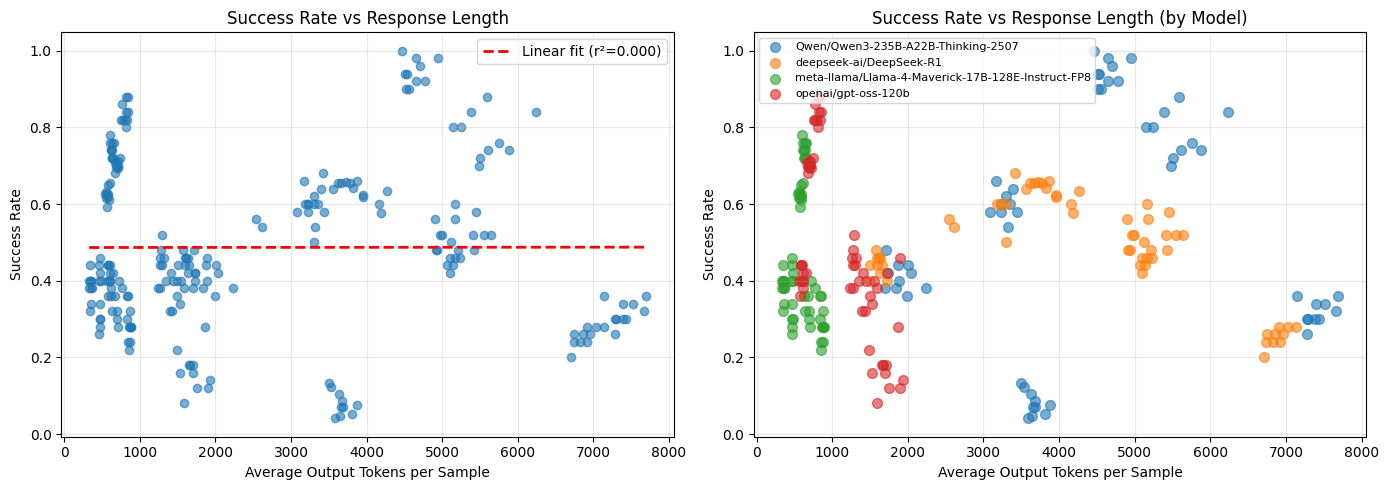

In [4]:
# Visualize the relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
ax = axes[0]
ax.scatter(df['avg_tokens_out'], df['success_rate'], alpha=0.6)
z = np.polyfit(df['avg_tokens_out'], df['success_rate'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['avg_tokens_out'].min(), df['avg_tokens_out'].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Linear fit (r²={r_value**2:.3f})')
ax.set_xlabel('Average Output Tokens per Sample')
ax.set_ylabel('Success Rate')
ax.set_title('Success Rate vs Response Length')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter plot by model
ax = axes[1]
for model_name in sorted(df['Model'].unique()):
    model_data = df[df['Model'] == model_name]
    ax.scatter(model_data['avg_tokens_out'], model_data['success_rate'], label=model_name, alpha=0.6, s=50)
ax.set_xlabel('Average Output Tokens per Sample')
ax.set_ylabel('Success Rate')
ax.set_title('Success Rate vs Response Length (by Model)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Analysis (non-aggregated)

### By Benchmark

In [5]:
# Analyze by benchmark
print("Analysis by Benchmark:")
print("=" * 80)
for benchmark in sorted(df['Benchmark'].unique()):
    bench_data = df[df['Benchmark'] == benchmark]
    corr = bench_data['success_rate'].corr(bench_data['avg_tokens_out'])
    print(f"\n{benchmark}: {len(bench_data)} experiments")
    print(f"  Correlation: {corr:.4f}")
    print(f"  Success rate range: {bench_data['success_rate'].min():.2f} - {bench_data['success_rate'].max():.2f}")
    print(f"  Avg tokens range: {bench_data['avg_tokens_out'].min():.0f} - {bench_data['avg_tokens_out'].max():.0f}")

Analysis by Benchmark:

game24: 40 experiments
  Correlation: 0.6739
  Success rate range: 0.28 - 1.00
  Avg tokens range: 608 - 5642

hle: 40 experiments
  Correlation: 0.4531
  Success rate range: 0.08 - 0.36
  Avg tokens range: 833 - 7695

hotpotqa: 40 experiments
  Correlation: 0.3457
  Success rate range: 0.32 - 0.48
  Avg tokens range: 330 - 2238

humaneval: 40 experiments
  Correlation: -0.5627
  Success rate range: 0.04 - 0.72
  Avg tokens range: 546 - 4270

scibench: 39 experiments
  Correlation: -0.9396
  Success rate range: 0.42 - 0.88
  Avg tokens range: 602 - 5232

sonnetwriting: 39 experiments
  Correlation: 0.9368
  Success rate range: 0.26 - 0.88
  Avg tokens range: 457 - 6240


### By Model

In [6]:
# Analyze by model
print("Analysis by Model:")
print("=" * 80)
for model in sorted(df['Model'].unique()):
    model_data = df[df['Model'] == model]
    corr = model_data['success_rate'].corr(model_data['avg_tokens_out'])
    print(f"\n{model}: {len(model_data)} experiments")
    print(f"  Correlation: {corr:.4f}")
    print(f"  Success rate range: {model_data['success_rate'].min():.2f} - {model_data['success_rate'].max():.2f}")
    print(f"  Avg tokens range: {model_data['avg_tokens_out'].min():.0f} - {model_data['avg_tokens_out'].max():.0f}")

Analysis by Model:

Qwen/Qwen3-235B-A22B-Thinking-2507: 59 experiments
  Correlation: 0.1037
  Success rate range: 0.04 - 1.00
  Avg tokens range: 1699 - 7695

deepseek-ai/DeepSeek-R1: 59 experiments
  Correlation: -0.4659
  Success rate range: 0.20 - 0.68
  Avg tokens range: 1499 - 7137

meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8: 60 experiments
  Correlation: -0.1298
  Success rate range: 0.22 - 0.78
  Avg tokens range: 330 - 887

openai/gpt-oss-120b: 60 experiments
  Correlation: -0.6867
  Success rate range: 0.08 - 0.88
  Avg tokens range: 563 - 1931


### Plots

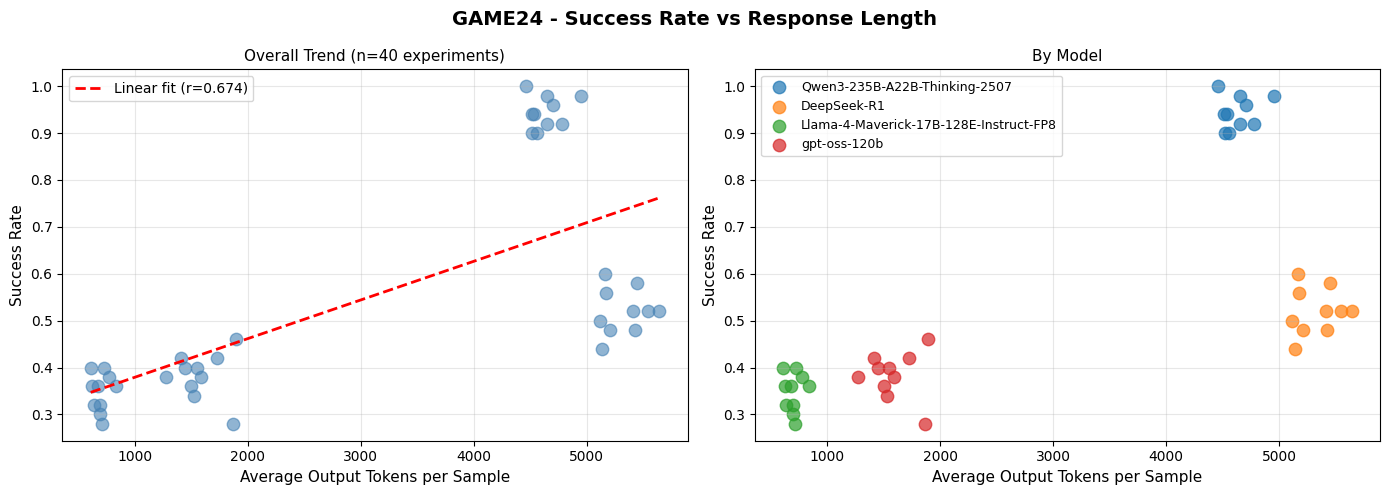


GAME24 Statistics:
  Correlation: 0.6739
  Success Rate Range: 28.0% - 100.0%
  Token Range: 608 - 5642



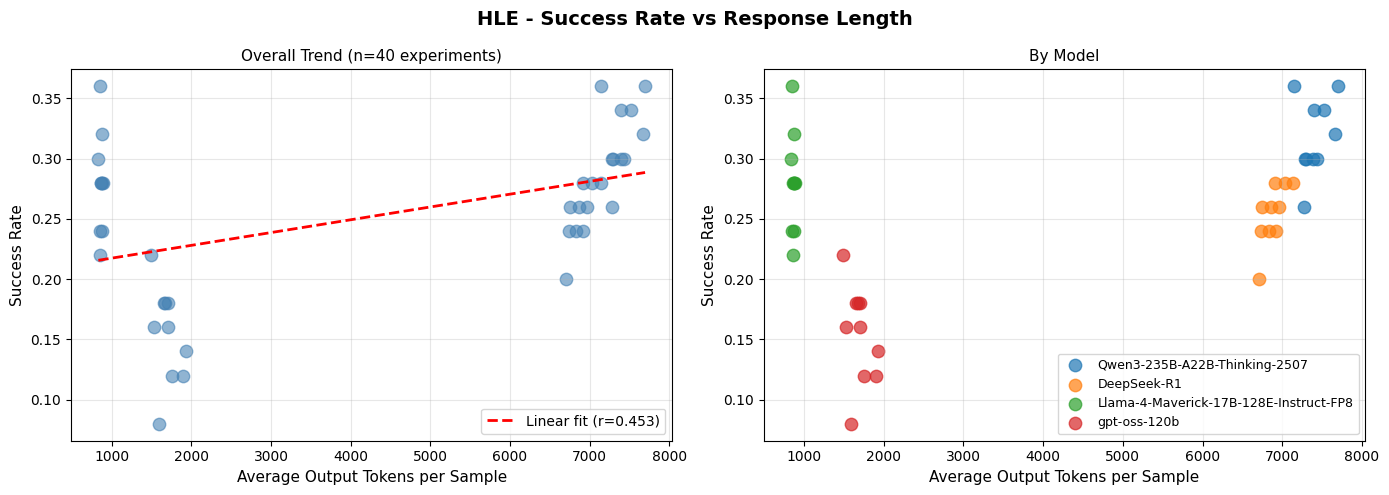


HLE Statistics:
  Correlation: 0.4531
  Success Rate Range: 8.0% - 36.0%
  Token Range: 833 - 7695



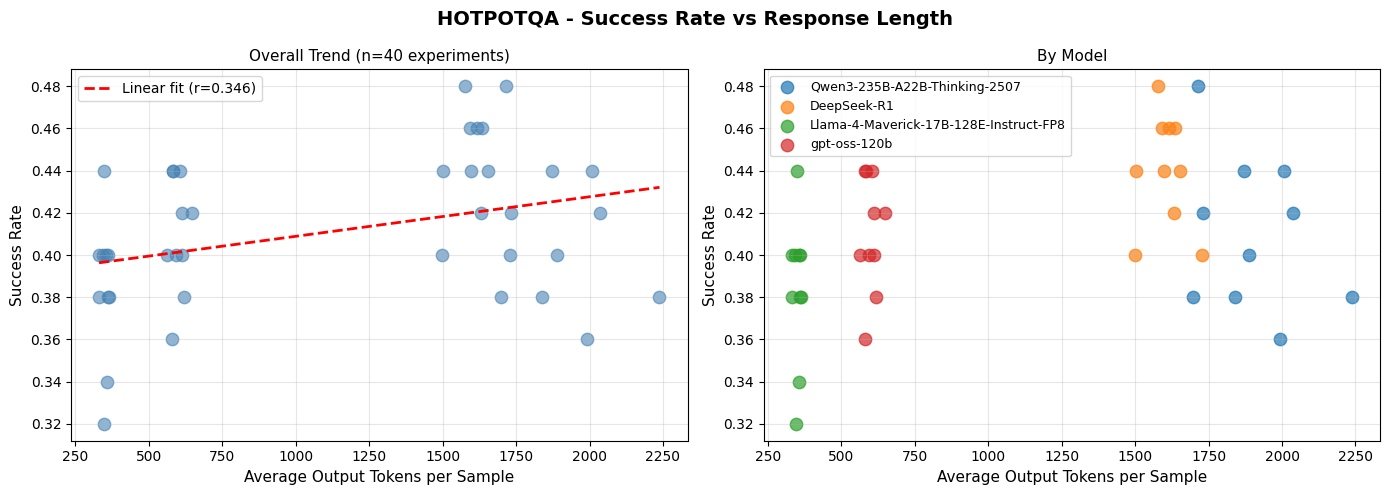


HOTPOTQA Statistics:
  Correlation: 0.3457
  Success Rate Range: 32.0% - 48.0%
  Token Range: 330 - 2238



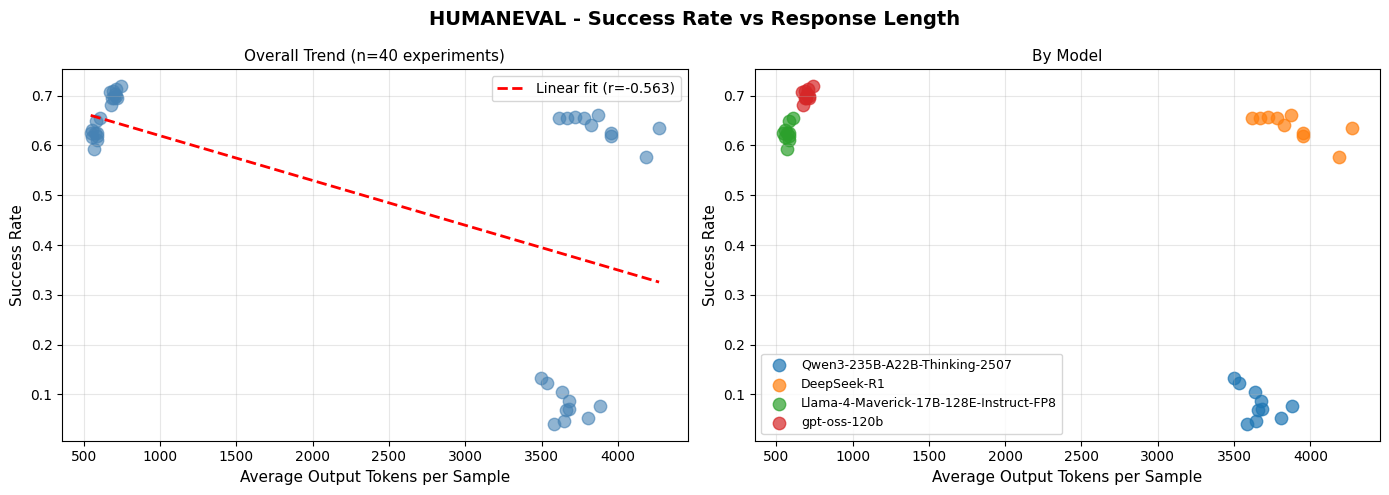


HUMANEVAL Statistics:
  Correlation: -0.5627
  Success Rate Range: 4.1% - 71.9%
  Token Range: 546 - 4270



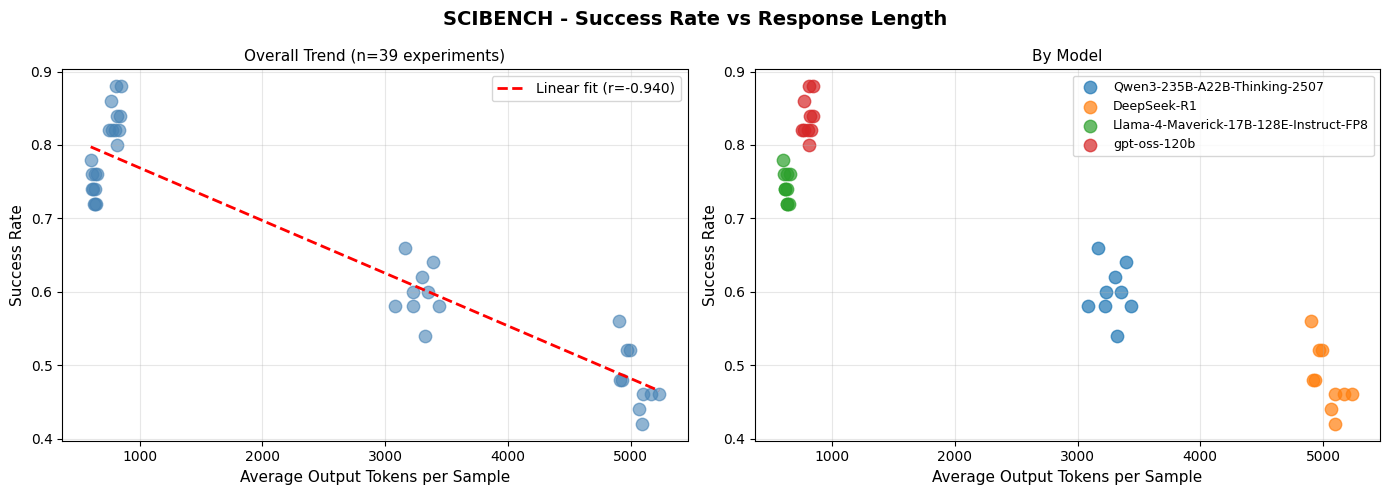


SCIBENCH Statistics:
  Correlation: -0.9396
  Success Rate Range: 42.0% - 88.0%
  Token Range: 602 - 5232



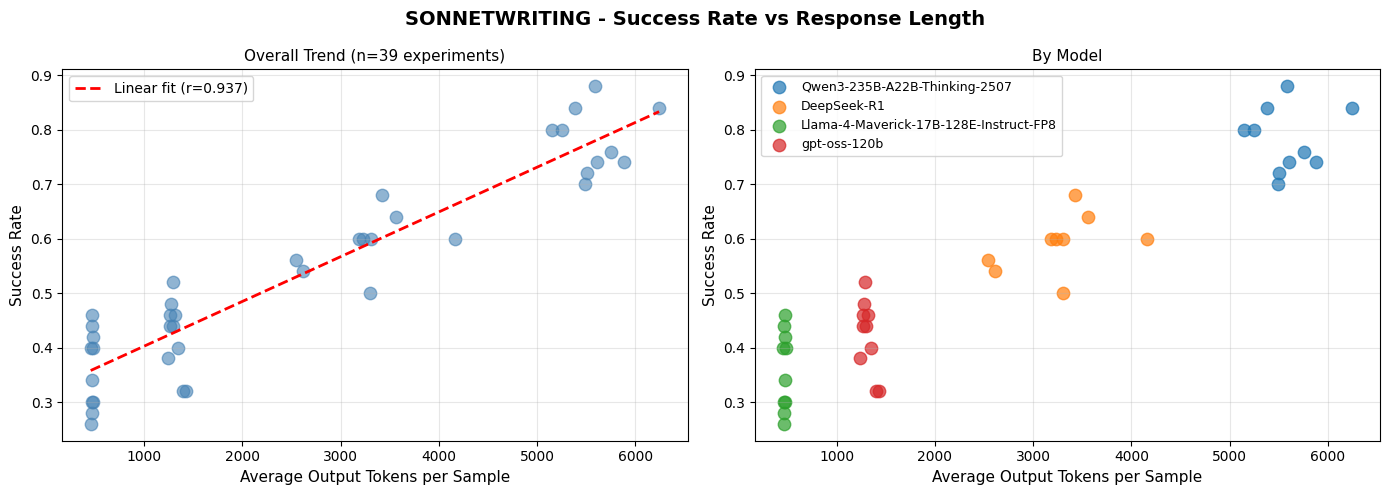


SONNETWRITING Statistics:
  Correlation: 0.9368
  Success Rate Range: 26.0% - 88.0%
  Token Range: 457 - 6240



In [7]:
# Visualize Success Rate vs Response Length by Benchmark

benchmarks = sorted(df['Benchmark'].unique())
colors = {'Qwen/Qwen3-235B-A22B-Thinking-2507': '#1f77b4',
          'deepseek-ai/DeepSeek-R1': '#ff7f0e',
          'meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8': '#2ca02c',
          'openai/gpt-oss-120b': '#d62728'}

for benchmark in benchmarks:
    bench_data = df[df['Benchmark'] == benchmark]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{benchmark.upper()} - Success Rate vs Response Length', fontsize=14, fontweight='bold')
    
    # Left plot: Overall scatter with regression line
    ax = axes[0]
    ax.scatter(bench_data['avg_tokens_out'], bench_data['success_rate'], alpha=0.6, s=80, color='steelblue')
    
    # Add regression line
    if len(bench_data) > 1:
        z = np.polyfit(bench_data['avg_tokens_out'], bench_data['success_rate'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(bench_data['avg_tokens_out'].min(), bench_data['avg_tokens_out'].max(), 100)
        corr = bench_data['success_rate'].corr(bench_data['avg_tokens_out'])
        ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Linear fit (r={corr:.3f})')
    
    ax.set_xlabel('Average Output Tokens per Sample', fontsize=11)
    ax.set_ylabel('Success Rate', fontsize=11)
    ax.set_title(f'Overall Trend (n={len(bench_data)} experiments)', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Right plot: Scatter plot by model
    ax = axes[1]
    for model_name in sorted(bench_data['Model'].unique()):
        model_data = bench_data[bench_data['Model'] == model_name]
        ax.scatter(model_data['avg_tokens_out'], model_data['success_rate'], 
                  label=model_name.split('/')[-1], alpha=0.7, s=80, 
                  color=colors.get(model_name, 'gray'))
    
    ax.set_xlabel('Average Output Tokens per Sample', fontsize=11)
    ax.set_ylabel('Success Rate', fontsize=11)
    ax.set_title(f'By Model', fontsize=11)
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{benchmark.upper()} Statistics:")
    print(f"  Correlation: {bench_data['success_rate'].corr(bench_data['avg_tokens_out']):.4f}")
    print(f"  Success Rate Range: {bench_data['success_rate'].min():.1%} - {bench_data['success_rate'].max():.1%}")
    print(f"  Token Range: {bench_data['avg_tokens_out'].min():.0f} - {bench_data['avg_tokens_out'].max():.0f}")
    print()


## Per-Sample Analysis: Token Usage vs Score Across Repeated Runs


SAMPLE CATEGORY DISTRIBUTION HEATMAP


/Users/nearchospotamitis/opt/anaconda3/envs/CacheSaver/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nearchospotamitis/opt/anaconda3/envs/CacheSaver/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nearchospotamitis/opt/anaconda3/envs/CacheSaver/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nearchospotamitis/opt/anaconda3/envs/CacheSaver/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nearchospotamitis/opt/anaconda3/envs/CacheSaver/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nea

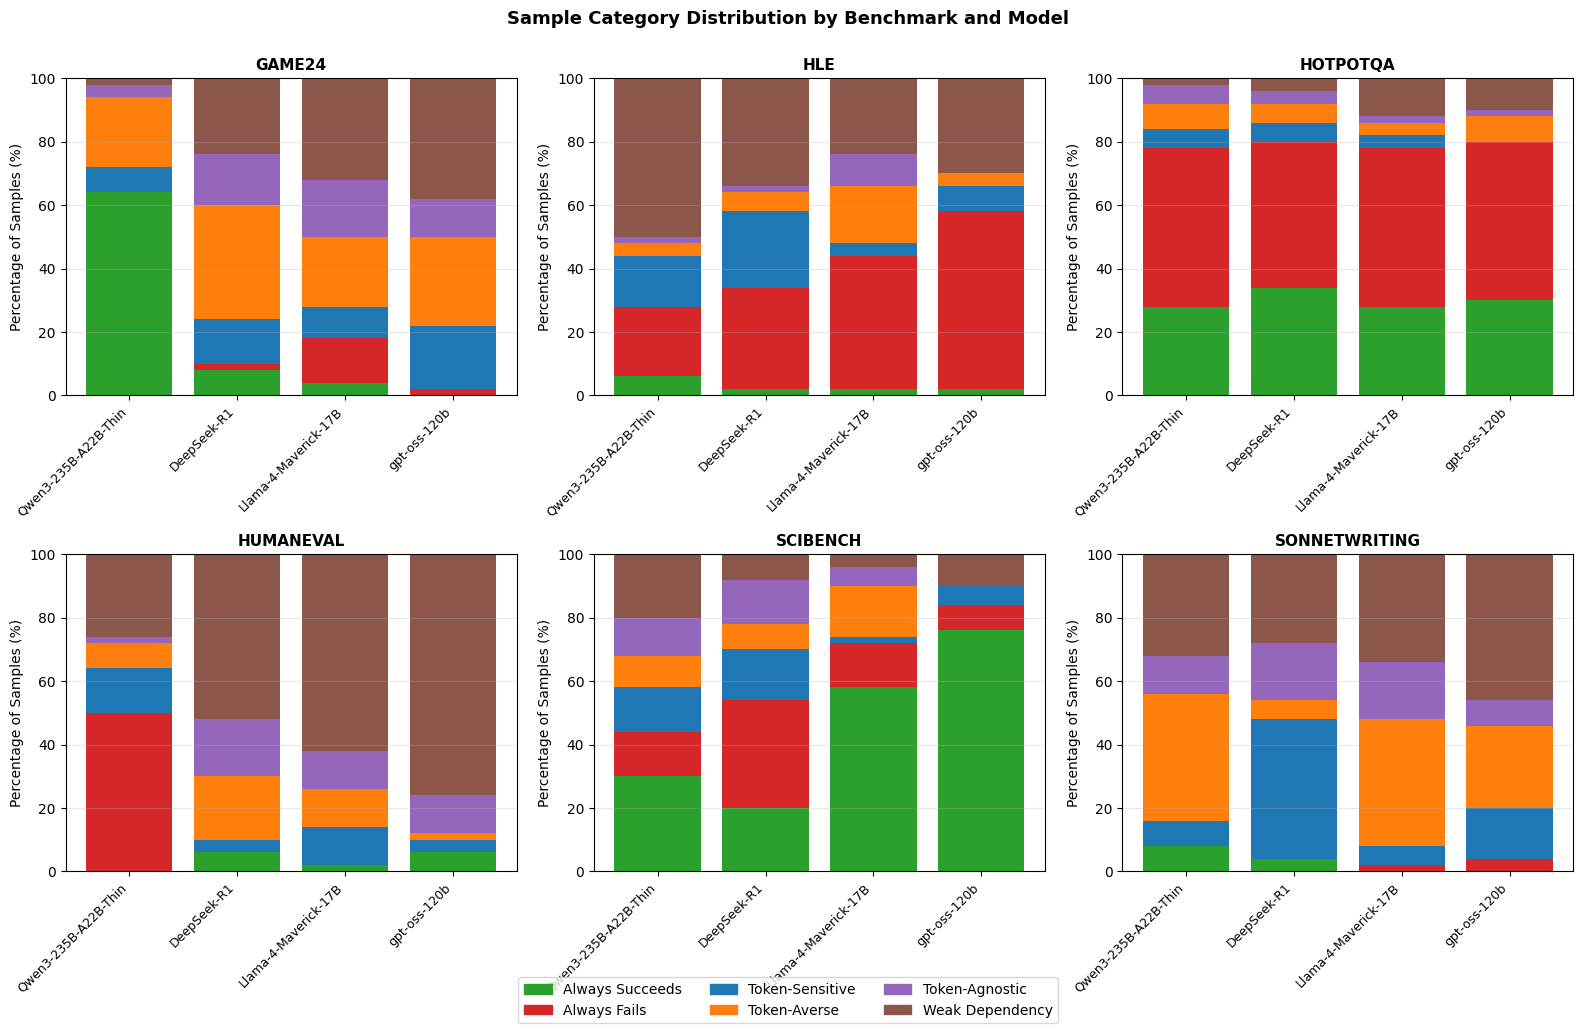

In [8]:
# Visualize sample category distributions

print("\n" + "=" * 100)
print("SAMPLE CATEGORY DISTRIBUTION HEATMAP")
print("=" * 100)

# Create data for heatmap
category_names = ['Always Succeeds', 'Always Fails', 'Token-Sensitive', 'Token-Averse', 'Token-Agnostic', 'Weak Dependency']
benchmarks = sorted(df['Benchmark'].unique())
models = sorted(df['Model'].unique())

# For each benchmark, show proportion of token-averse samples (since that's the key finding)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for bench_idx, benchmark in enumerate(benchmarks):
    ax = axes[bench_idx]
    
    token_averse_pcts = []
    model_labels = []
    
    for model in models:
        result = categorize_samples(df, benchmark, model)
        if result is None:
            continue
        
        cats = result['categories']
        total = result['num_samples']
        
        # Calculate percentages
        always_succ = len(cats['ALWAYS_SUCCEEDS']) / total * 100
        always_fail = len(cats['ALWAYS_FAILS']) / total * 100
        token_sens = len(cats['TOKEN_SENSITIVE_POS']) / total * 100
        token_averse = len(cats['TOKEN_AVERSE']) / total * 100
        token_agno = len(cats['TOKEN_AGNOSTIC']) / total * 100
        weak_dep = len(cats['WEAK_DEPENDENCY']) / total * 100
        
        # Stacked bar chart
        x_pos = len(model_labels)
        ax.bar(x_pos, always_succ, label='Always Succeeds', color='#2ca02c')
        ax.bar(x_pos, always_fail, bottom=always_succ, label='Always Fails', color='#d62728')
        ax.bar(x_pos, token_sens, bottom=always_succ+always_fail, label='Token-Sensitive (+)', color='#1f77b4')
        ax.bar(x_pos, token_averse, bottom=always_succ+always_fail+token_sens, label='Token-Averse (-)', color='#ff7f0e')
        ax.bar(x_pos, token_agno, bottom=always_succ+always_fail+token_sens+token_averse, label='Token-Agnostic', color='#9467bd')
        ax.bar(x_pos, weak_dep, bottom=always_succ+always_fail+token_sens+token_averse+token_agno, label='Weak Dependency', color='#8c564b')
        
        model_labels.append(model.split('/')[-1][:20])
    
    ax.set_xticks(range(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Percentage of Samples (%)', fontsize=10)
    ax.set_title(f'{benchmark.upper()}', fontsize=11, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')

# Add legend at the end
handles = [
    plt.Rectangle((0,0),1,1, color='#2ca02c'),
    plt.Rectangle((0,0),1,1, color='#d62728'),
    plt.Rectangle((0,0),1,1, color='#1f77b4'),
    plt.Rectangle((0,0),1,1, color='#ff7f0e'),
    plt.Rectangle((0,0),1,1, color='#9467bd'),
    plt.Rectangle((0,0),1,1, color='#8c564b'),
]
fig.legend(handles, category_names, loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Sample Category Distribution by Benchmark and Model', fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()
